In [1]:
! pip install pydriller


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! git clone https://github.com/ansible/molecule
! git clone https://github.com/andialbrecht/sqlparse
! git clone https://github.com/amidaware/tacticalrmm

Cloning into 'molecule'...
Cloning into 'sqlparse'...
Cloning into 'tacticalrmm'...


In [22]:
from pydriller import Repository
import csv, os

# Repositories (using GitHub links directly)
repos = [
    "https://github.com/ansible/molecule.git",
    "https://github.com/andialbrecht/sqlparse.git",
    "https://github.com/amidaware/tacticalrmm.git"
]

# Ensure "data" folder exists
os.makedirs("data", exist_ok=True)

# Output CSV
out_file = "data/raw_commits.csv"

with open(out_file, "w", newline="", encoding="utf-8") as fh:
    writer = csv.writer(fh)
    writer.writerow(['repo', 'commit_sha', 'parent_sha', 'commit_msg', 'old_path', 'new_path'])

    for repo in repos:
        print("Mining:", repo)
        for commit in Repository(path_to_repo=repo).traverse_commits():
            if not commit.parents:   # skip root commits
                continue
            parent_sha = commit.parents[0]
            for mod in commit.modified_files:  # ✅ updated here
                writer.writerow([
                    repo.split("/")[-1].replace(".git",""),  # repo name from URL
                    commit.hash,
                    parent_sha,
                    commit.msg.replace('\n', ' '),
                    mod.old_path,
                    mod.new_path
                ])

print(f"✅ Mining complete. Results saved to {out_file}")



Mining: https://github.com/ansible/molecule.git
Mining: https://github.com/andialbrecht/sqlparse.git
Mining: https://github.com/amidaware/tacticalrmm.git
✅ Mining complete. Results saved to data/raw_commits.csv


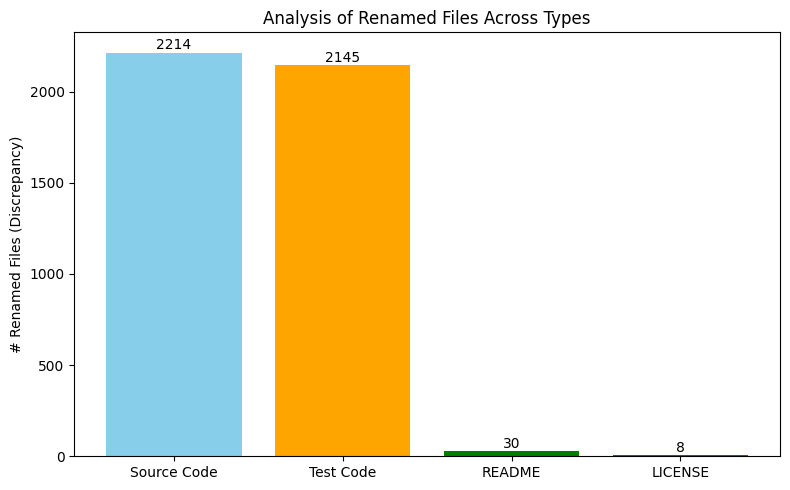

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy for the np.where function

# Load dataset
df = pd.read_csv(r"C:\Users\Grace\OneDrive\Desktop\lab\raw_commits.csv")

# Clean column names: strip spaces and lowercase
df.columns = df.columns.str.strip().str.lower()

# --- STEP 1: DEFINE THE DISCREPANCY ---
# We see there is no 'discrepancy' column.
# Let's define a discrepancy as a file being renamed (when old_path is different from new_path).
# We will create a new column called 'discrepancy' to hold this information.
# np.where is a fast way to do an if-else operation to create a new column.
df['discrepancy'] = np.where(df['old_path'] != df['new_path'], 'Yes', 'No')


# --- STEP 2: USE THE CORRECT COLUMN NAMES ---
# Now we can set our variables to the correct names.
# 'new_path' is our file path column.
# 'discrepancy' is the column we just created.
file_path_col = 'new_path'
discrepancy_col = 'discrepancy'


# --- The rest of your code now works perfectly ---

# Filters based on file types and keywords
# Using .astype(str) to prevent errors if some paths are not strings
source_code = df[df[file_path_col].astype(str).str.endswith(('.py', '.java', '.c', '.cpp', '.kts', '.sh', '.js'), na=False)]
tests       = df[df[file_path_col].astype(str).str.contains("test", case=False, na=False)]
readme      = df[df[file_path_col].astype(str).str.contains("readme", case=False, na=False)]
license_f   = df[df[file_path_col].astype(str).str.contains("license", case=False, na=False)]

# Count mismatches (which we have defined as renames)
stats = {
    "Source Code": (source_code[discrepancy_col] == "Yes").sum(),
    "Test Code": (tests[discrepancy_col] == "Yes").sum(),
    "README": (readme[discrepancy_col] == "Yes").sum(),
    "LICENSE": (license_f[discrepancy_col] == "Yes").sum(),
}

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(stats.keys(), stats.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylabel("# Renamed Files (Discrepancy)")
plt.title("Analysis of Renamed Files Across Types")

# Show counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()